<a href="https://colab.research.google.com/github/vivekvj18/ML-PROJECT-2/blob/main/ML_2(LINEAR_SVM_81_88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded dataframe shape: (145890, 55)
Target: Cover_Type | #features: 54 (continuous 10, binary 44)
Dropped 1 rows due to NaN/inf (if any). New shape: (145889, 55)
Train / Test shapes: (116711, 54) (29178, 54)

Baseline LinearSVC training time: 36.66 sec

--- Baseline LinearSVC Results ---
Accuracy : 0.8188
Macro-F1 : 0.6524

Classification Report (baseline):
              precision    recall  f1-score   support

           1     0.7910    0.4198    0.5485      6222
           2     0.8325    0.9677    0.8951     20614
           3     0.6322    0.5370    0.5807       432
           4     0.7821    0.8889    0.8321       432
           5     0.5412    0.2248    0.3176       614
           6     0.5685    0.5764    0.5724       432
           7     0.8981    0.7546    0.8201       432

    accuracy                         0.8188     29178
   macro avg     0.7208    0.6242    0.6524     29178
weighted avg     0.8109    0.8188    0.7975     29178



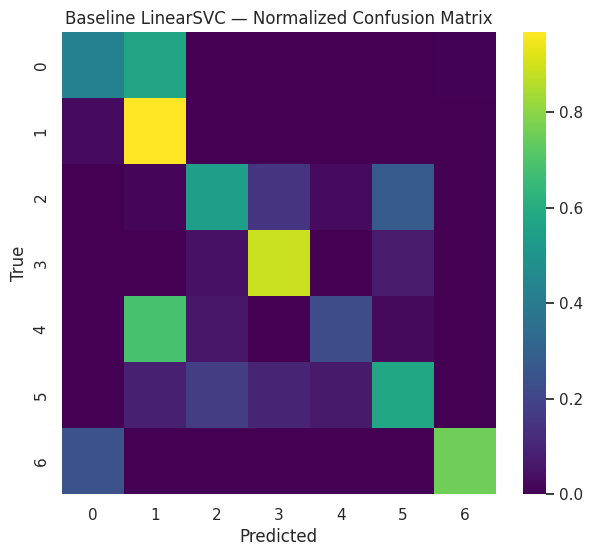


Starting GridSearchCV for LinearSVC (this can take a bit longer)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV done in 234.53 sec
Best params: {'clf__C': 5.0, 'clf__class_weight': 'balanced'}
Best CV f1_macro: 0.6669143991743904

--- Tuned LinearSVC Results ---
Test Accuracy : 0.8044
Test Macro-F1 : 0.6757

Classification Report (tuned):
              precision    recall  f1-score   support

           1     0.6536    0.5268    0.5834      6222
           2     0.8622    0.9039    0.8826     20614
           3     0.5880    0.5648    0.5762       432
           4     0.8057    0.8449    0.8249       432
           5     0.4056    0.4267    0.4159       614
           6     0.5586    0.6620    0.6059       432
           7     0.7672    0.9306    0.8410       432

    accuracy                         0.8044     29178
   macro avg     0.6630    0.6943    0.6757     29178
weighted avg     0.7973    0.8044    0.7989     29178



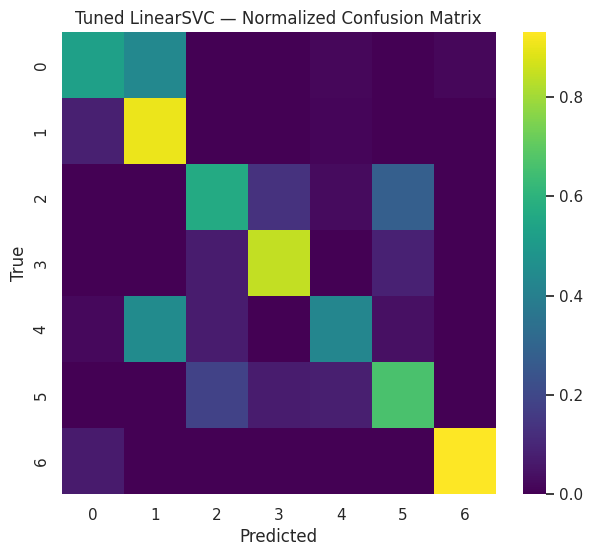

5-fold CV macro-F1 scores (train): [0.6615 0.6625 0.6739 0.6628 0.6739]
CV mean (train): 0.6669

REPORT SNIPPET (copy to your report; edit numbers if needed):

Linear SVM (LinearSVC) — baseline accuracy=0.8188, baseline macro-F1=0.6524.
Tuned LinearSVC (GridSearch over C & class_weight) achieved test accuracy=0.8044 and macro-F1=0.6757.
Observation: Both Logistic Regression and Linear SVM are linear models; improvements are modest because the dataset has complex non-linear interactions (seen from PCA).
Concluding note: LinearSVC gives a reliable linear baseline; for major accuracy gains we need non-linear models (RBF SVM, Neural Network).


10229

In [ ]:
# ===========================
# Linear SVM (LinearSVC) — Full cell for a separate notebook
# Paste & run in a NEW notebook. Ensure covtype.csv is uploaded.
# ===========================

# Imports (redundant-safe)
import time, joblib, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
RANDOM_STATE = 42

# ---------------------------
# 1) Load dataset
# ---------------------------
DATA_PATH = "covtype.csv"   # change if file path differs
df = pd.read_csv(DATA_PATH)
print("Loaded dataframe shape:", df.shape)

# ---------------------------
# 2) Columns definition (UCI covtype)
# ---------------------------
continuous_cols = [
    'Elevation','Aspect','Slope',
    'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

# detect target
target_col = 'Cover_Type' if 'Cover_Type' in df.columns else df.columns[-1]
feature_cols = [c for c in df.columns if c != target_col]
binary_cols = [c for c in feature_cols if c not in continuous_cols]

print(f"Target: {target_col} | #features: {len(feature_cols)} (continuous {len(continuous_cols)}, binary {len(binary_cols)})")

# ---------------------------
# 3) Quick cleaning: drop rows with NaN target; drop rows with NaN/inf in features
# ---------------------------
# If your data is already clean, these operations won't drop anything.
initial_rows = len(df)
df = df.dropna(subset=[target_col])
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
print(f"Dropped {initial_rows - len(df)} rows due to NaN/inf (if any). New shape: {df.shape}")

# ensure integer labels
df[target_col] = df[target_col].astype(int)

# ---------------------------
# 4) Train-test split (stratified)
# ---------------------------
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train / Test shapes:", X_train.shape, X_test.shape)

# ---------------------------
# 5) Preprocessor: scale continuous only
# ---------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols)
    ],
    remainder='passthrough'  # binary features are left unchanged
)

# ---------------------------
# 6) Option A: Baseline LinearSVC pipeline (fast)
# ---------------------------
pipe_baseline = Pipeline([
    ('pre', preprocessor),
    ('clf', LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=5000))
])

t0 = time.time()
pipe_baseline.fit(X_train, y_train)
t1 = time.time()
print(f"\nBaseline LinearSVC training time: {t1 - t0:.2f} sec")

# Evaluate baseline
y_pred_base = pipe_baseline.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average='macro')

print("\n--- Baseline LinearSVC Results ---")
print("Accuracy :", round(acc_base, 4))
print("Macro-F1 :", round(f1_base, 4))
print("\nClassification Report (baseline):")
print(classification_report(y_test, y_pred_base, digits=4))

# Normalized confusion matrix plot
cm = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(7,6))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap='viridis')
plt.title("Baseline LinearSVC — Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save baseline (optional)
joblib.dump(pipe_baseline, "linear_svc_baseline.pkl")

# ---------------------------
# 7) Option B: Tuned LinearSVC via GridSearchCV (recommended)
# We'll search over C and class_weight. Small grid to keep runtime low.
# ---------------------------
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 5.0],
    'clf__class_weight': [None, 'balanced']
}

# Build pipeline (note: instantiate a fresh LinearSVC inside pipeline)
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=5000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=2)

print("\nStarting GridSearchCV for LinearSVC (this can take a bit longer)...")
t0 = time.time()
gs.fit(X_train, y_train)
t1 = time.time()
print(f"GridSearchCV done in {(t1 - t0):.2f} sec")
print("Best params:", gs.best_params_)
print("Best CV f1_macro:", gs.best_score_)

best_pipe = gs.best_estimator_

# Evaluate best on test set
y_pred = best_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro')

print("\n--- Tuned LinearSVC Results ---")
print("Test Accuracy :", round(acc, 4))
print("Test Macro-F1 :", round(f1m, 4))
print("\nClassification Report (tuned):")
print(classification_report(y_test, y_pred, digits=4))

# Plot normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), cmap='viridis')
plt.title("Tuned LinearSVC — Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 5-fold CV on training set for best estimator (robustness)
cv_scores = cross_val_score(best_pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print("5-fold CV macro-F1 scores (train):", np.round(cv_scores,4))
print("CV mean (train):", np.round(cv_scores.mean(),4))

# Save best pipeline
joblib.dump(best_pipe, "linear_svc_tuned.pkl")

# ---------------------------
# 8) Short report text to paste (edit numbers if you want)
# ---------------------------
print("\nREPORT SNIPPET (copy to your report; edit numbers if needed):\n")
print(f"Linear SVM (LinearSVC) — baseline accuracy={acc_base:.4f}, baseline macro-F1={f1_base:.4f}.")
print(f"Tuned LinearSVC (GridSearch over C & class_weight) achieved test accuracy={acc:.4f} and macro-F1={f1m:.4f}.")
print("Observation: Both Logistic Regression and Linear SVM are linear models; improvements are modest because the dataset has complex non-linear interactions (seen from PCA).")
print("Concluding note: LinearSVC gives a reliable linear baseline; for major accuracy gains we need non-linear models (RBF SVM, Neural Network).")

# ---------------------------
# 9) Clean up (optional)
# ---------------------------
gc.collect()
